In [60]:
# Off-Cycle Defrost Analysis - Hardening Room Freezer System
# Analysis of power consumption with off-cycle defrost detection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import find_peaks
from sklearn.cluster import KMeans

import os

In [61]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Off-Cycle Defrost Analysis - Hardening Room Freezer System")
print("=========================================================")
print("Equipment: Hardening Room Freezer")
print("Defrost Type: Off-Cycle (Compressor Off, Evaporator Fans Continue)")
print("Analysis Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print()

Off-Cycle Defrost Analysis - Hardening Room Freezer System
Equipment: Hardening Room Freezer
Defrost Type: Off-Cycle (Compressor Off, Evaporator Fans Continue)
Analysis Date: 2025-08-27 15:17:14



In [62]:
## 1. DATA LOADING AND CLEANING

def load_power_data(filename):
    """Load power meter data from CSV file"""
    try:
        df = pd.read_csv(filename)
        print(f"Raw data loaded: {len(df)} records")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def clean_power_data(df):
    """Clean and prepare power meter data for off-cycle defrost analysis"""
    df_clean = df.copy()
    
    # Convert time column to datetime
    df_clean['time'] = pd.to_datetime(df_clean['time'])
    
    # Ensure numeric columns are properly typed
    numeric_columns = ['raw_mamp', 'ampere', 'volt', 'power_factor', 'power_total']
    for col in numeric_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Remove any rows with missing critical data
    df_clean = df_clean.dropna(subset=['time', 'power_total'])
    
    # Sort by time
    df_clean = df_clean.sort_values('time').reset_index(drop=True)
    
    # Calculate time differences for interval analysis
    df_clean['time_diff'] = df_clean['time'].diff().dt.total_seconds() / 60  # minutes
    
    # Calculate power metrics
    df_clean['apparent_power'] = df_clean['ampere'] * df_clean['volt'] / 1000  # kVA
    df_clean['reactive_power'] = np.sqrt(np.maximum(0, df_clean['apparent_power']**2 - df_clean['power_total']**2))  # kVAR
    
    print(f"\nCleaned data: {len(df_clean)} valid records")
    print(f"Time range: {df_clean['time'].min()} to {df_clean['time'].max()}")
    print(f"Monitoring period: {(df_clean['time'].max() - df_clean['time'].min()).days:.1f} days")
    print(f"Average sampling interval: {df_clean['time_diff'].median():.1f} minutes")
    print(f"Power range: {df_clean['power_total'].min():.2f} to {df_clean['power_total'].max():.2f} kW")
    
    return df_clean

# Load and clean the data
print("Loading Hardening Room power meter data...")
df_raw = load_power_data('output/cleaned_Hardening_Room.csv')

if df_raw is not None:
    df = clean_power_data(df_raw)
    print(f"\nEquipment ID: {df['equipment_id'].iloc[0]}")
else:
    print("Failed to load data")
    df = None


Loading Hardening Room power meter data...
Raw data loaded: 16393 records
Columns: ['time', 'raw_mamp', 'ampere', 'volt', 'power_factor', 'power_total', 'equipment_id']

Cleaned data: 16393 valid records
Time range: 2025-07-01 00:04:00 to 2025-08-27 14:51:00
Monitoring period: 57.0 days
Average sampling interval: 5.0 minutes
Power range: 0.13 to 54.50 kW

Equipment ID: Hardening Room


In [63]:
## 2. POWER CONSUMPTION METRICS ANALYSIS

def calculate_freezer_power_metrics(df):
    """Calculate power consumption metrics for freezer with off-cycle defrost"""
    
    metrics = {}
    
    # Basic power statistics
    metrics['total_records'] = len(df)
    metrics['monitoring_hours'] = (df['time'].max() - df['time'].min()).total_seconds() / 3600
    metrics['average_interval_min'] = df['time_diff'].median()
    
    # Identify operational modes using percentiles (for off-cycle defrost)
    metrics['min_power_kw'] = df['power_total'].min()
    metrics['p05_power_kw'] = df['power_total'].quantile(0.05)  # Likely defrost (fans only)
    metrics['p25_power_kw'] = df['power_total'].quantile(0.25)
    metrics['mean_power_kw'] = df['power_total'].mean()
    metrics['p75_power_kw'] = df['power_total'].quantile(0.75)
    metrics['p95_power_kw'] = df['power_total'].quantile(0.95)  # Normal operation
    metrics['max_power_kw'] = df['power_total'].max()
    metrics['std_power_kw'] = df['power_total'].std()
    
    # Estimate operational modes
    metrics['fan_only_power'] = metrics['p25_power_kw']  # Evaporator fans during defrost
    metrics['normal_operation_power'] = metrics['p95_power_kw']  # Full refrigeration
    
    # Energy calculations
    time_hours = df['time_diff'].fillna(df['time_diff'].median()) / 60  # convert to hours
    metrics['total_energy_kwh'] = (df['power_total'] * time_hours).sum()
    metrics['average_hourly_consumption'] = metrics['total_energy_kwh'] / metrics['monitoring_hours']
    
    # Electrical parameters
    metrics['average_voltage'] = df['volt'].mean()
    metrics['average_current'] = df['ampere'].mean()
    metrics['average_power_factor'] = df['power_factor'].mean()
    metrics['max_current'] = df['ampere'].max()
    
    # Load factor analysis
    metrics['load_factor'] = metrics['mean_power_kw'] / metrics['max_power_kw']
    
    return metrics

# Calculate power metrics
print("\n" + "="*70)
print("FREEZER POWER CONSUMPTION METRICS")
print("="*70)

if df is not None:
    metrics = calculate_freezer_power_metrics(df)
    
    print(f"Equipment: {df['equipment_id'].iloc[0]}")
    print(f"Monitoring Period: {metrics['monitoring_hours']:.1f} hours ({metrics['monitoring_hours']/24:.1f} days)")
    print(f"Data Points: {metrics['total_records']:,}")
    print(f"Sampling Interval: {metrics['average_interval_min']:.1f} minutes")
    print()
    print("POWER STATISTICS:")
    print(f"  Mean Power: {metrics['mean_power_kw']:.2f} kW")
    print(f"  Peak Power: {metrics['max_power_kw']:.2f} kW")
    print(f"  Minimum Power: {metrics['min_power_kw']:.2f} kW")
    print(f"  Standard Deviation: {metrics['std_power_kw']:.2f} kW")
    print(f"  Load Factor: {metrics['load_factor']:.2f}")
    print()
    print("OPERATIONAL MODES (estimated):")
    print(f"  Fan-Only Power (Defrost): {metrics['fan_only_power']:.2f} kW")
    print(f"  Normal Operation: {metrics['normal_operation_power']:.2f} kW")
    print(f"  Power Range: {metrics['p25_power_kw']:.1f} - {metrics['p75_power_kw']:.1f} kW (25th-75th percentile)")
    print()
    print("ENERGY CONSUMPTION:")
    print(f"  Total Energy: {metrics['total_energy_kwh']:.1f} kWh")
    print(f"  Average Hourly: {metrics['average_hourly_consumption']:.2f} kW")
    print(f"  Daily Average: {metrics['average_hourly_consumption']*24:.1f} kWh/day")
    print()
    print("ELECTRICAL PARAMETERS:")
    print(f"  Average Voltage: {metrics['average_voltage']:.0f} V")
    print(f"  Average Current: {metrics['average_current']:.1f} A")
    print(f"  Peak Current: {metrics['max_current']:.1f} A")
    print(f"  Power Factor: {metrics['average_power_factor']:.2f}")



FREEZER POWER CONSUMPTION METRICS
Equipment: Hardening Room
Monitoring Period: 1382.8 hours (57.6 days)
Data Points: 16,393
Sampling Interval: 5.0 minutes

POWER STATISTICS:
  Mean Power: 20.77 kW
  Peak Power: 54.50 kW
  Minimum Power: 0.13 kW
  Standard Deviation: 16.80 kW
  Load Factor: 0.38

OPERATIONAL MODES (estimated):
  Fan-Only Power (Defrost): 0.13 kW
  Normal Operation: 38.00 kW
  Power Range: 0.1 - 36.4 kW (25th-75th percentile)

ENERGY CONSUMPTION:
  Total Energy: 28849.0 kWh
  Average Hourly: 20.86 kW
  Daily Average: 500.7 kWh/day

ELECTRICAL PARAMETERS:
  Average Voltage: 476 V
  Average Current: 31.5 A
  Peak Current: 82.6 A
  Power Factor: 0.80


In [64]:
## 3. OFF-CYCLE DEFROST ANALYSIS

# Define defrost thresholds
defrost_high_threshold = 20.0  # kW
defrost_low_threshold = 8.0  # kW
min_duration = 5  # minutes
min_gap = 60  # minutes


# Analyze off-cycle defrost events

def analyze_off_cycle_defrost(df, defrost_high_threshold=defrost_high_threshold, defrost_low_threshold=defrost_low_threshold, 
                              min_duration=min_duration, min_gap=min_gap):
    """
    Analyze off-cycle defrost cycles in freezer system
    
    Parameters:
    - defrost_high_threshold: Power level (kW) above which off-cycle defrost is occurring
    - defrost_low_threshold: Power level (kW) below which off-cycle defrost is occurring
    - min_duration: Minimum duration (minutes) for a valid defrost cycle
    - min_gap: Minimum gap (minutes) between defrost cycles
    """
    
    # Identify off-cycle defrost periods (LOW power consumption)
    df['is_defrost'] = (df['power_total'] <= defrost_high_threshold) & (df['power_total'] > defrost_low_threshold)
    df['is_defrost_int'] = df['is_defrost'].astype(int)

    # Find defrost cycle start and end times
    df['defrost_change'] = df['is_defrost_int'].diff()
    defrost_starts = df[df['defrost_change'] == 1].copy()  # Start of defrost (power drops)
    defrost_ends = df[df['defrost_change'] == -1].copy()   # End of defrost (power rises)
    
    # Handle edge cases - if starts with defrost
    if df['is_defrost'].iloc[0]:
        first_start = pd.DataFrame([{
            'time': df['time'].iloc[0],
            'power_total': df['power_total'].iloc[0],
            'defrost_change': 1
        }])
        defrost_starts = pd.concat([first_start, defrost_starts], ignore_index=True)
    
    # Handle edge cases - if ends with defrost
    if df['is_defrost'].iloc[-1]:
        last_end = pd.DataFrame([{
            'time': df['time'].iloc[-1],
            'power_total': df['power_total'].iloc[-1],
            'defrost_change': -1
        }])
        defrost_ends = pd.concat([defrost_ends, last_end], ignore_index=True)
    
    # Match starts with ends to create complete cycles
    defrost_cycles = []
    
    for _, start_row in defrost_starts.iterrows():
        # Find the next end after this start
        next_ends = defrost_ends[defrost_ends['time'] > start_row['time']]
        if not next_ends.empty:
            end_row = next_ends.iloc[0]
            
            # Calculate cycle duration
            duration = (end_row['time'] - start_row['time']).total_seconds() / 60  # minutes
            
            if duration >= min_duration:  # Only include cycles meeting minimum duration
                cycle_data = df[(df['time'] >= start_row['time']) & (df['time'] <= end_row['time'])]
                
                # For off-cycle defrost, we want to track the fan power consumption
                defrost_cycles.append({
                    'start_time': start_row['time'],
                    'end_time': end_row['time'],
                    'duration_min': duration,
                    'min_power_kw': cycle_data['power_total'].min(),
                    'max_power_kw': cycle_data['power_total'].max(),
                    'avg_power_kw': cycle_data['power_total'].mean(),
                    'fan_energy_kwh': (cycle_data['power_total'] * cycle_data['time_diff'].fillna(5) / 60).sum(),
                    'pre_defrost_power': df[df['time'] < start_row['time']]['power_total'].iloc[-5:].mean() if len(df[df['time'] < start_row['time']]) >= 5 else np.nan,
                    'post_defrost_power': df[df['time'] > end_row['time']]['power_total'].iloc[:5].mean() if len(df[df['time'] > end_row['time']]) >= 5 else np.nan
                })
    
    defrost_df = pd.DataFrame(defrost_cycles)
    
    if not defrost_df.empty:
        # Calculate time between defrost cycles
        defrost_df['time_since_last'] = defrost_df['start_time'].diff().dt.total_seconds() / 3600  # hours
        
        # Add day/hour analysis
        defrost_df['hour_of_day'] = defrost_df['start_time'].dt.hour
        defrost_df['day_of_week'] = defrost_df['start_time'].dt.day_name()
        defrost_df['date'] = defrost_df['start_time'].dt.date
        
        # Calculate power saved during defrost (compressor off)
        if 'pre_defrost_power' in defrost_df.columns:
            defrost_df['power_saved_kw'] = defrost_df['pre_defrost_power'] - defrost_df['avg_power_kw']
            defrost_df['energy_saved_kwh'] = defrost_df['power_saved_kw'] * (defrost_df['duration_min'] / 60)
    
    return defrost_df, df

def calculate_off_cycle_defrost_metrics(defrost_df, total_hours):
    """Calculate off-cycle defrost performance metrics"""
    
    if defrost_df.empty:
        return {"message": "No off-cycle defrost cycles detected"}
    
    metrics = {}
    
    # Cycle frequency and timing
    metrics['total_cycles'] = len(defrost_df)
    metrics['cycles_per_day'] = len(defrost_df) / (total_hours / 24)
    metrics['avg_cycle_duration'] = defrost_df['duration_min'].mean()
    metrics['avg_time_between_cycles'] = defrost_df['time_since_last'].mean()
    
    # Power during defrost (fan-only operation)
    metrics['avg_defrost_power'] = defrost_df['avg_power_kw'].mean()
    metrics['min_defrost_power'] = defrost_df['min_power_kw'].min()
    metrics['max_defrost_power'] = defrost_df['max_power_kw'].max()
    
    # Energy analysis
    metrics['total_fan_energy'] = defrost_df['fan_energy_kwh'].sum()
    metrics['avg_fan_energy_per_cycle'] = defrost_df['fan_energy_kwh'].mean()
    
    # Energy savings from compressor being off
    if 'energy_saved_kwh' in defrost_df.columns:
        saved_energy = defrost_df['energy_saved_kwh'].dropna()
        if not saved_energy.empty:
            metrics['total_energy_saved'] = saved_energy.sum()
            metrics['avg_energy_saved_per_cycle'] = saved_energy.mean()
    
    # Defrost efficiency
    total_defrost_time = defrost_df['duration_min'].sum() / 60  # hours
    metrics['defrost_time_percentage'] = (total_defrost_time / total_hours) * 100
    
    # Timing patterns
    metrics['most_common_hour'] = defrost_df['hour_of_day'].mode().iloc[0] if not defrost_df['hour_of_day'].mode().empty else None
    metrics['hour_distribution'] = defrost_df['hour_of_day'].value_counts().sort_index()
    
    return metrics

# Analyze off-cycle defrost
print("\n" + "="*70)
print("OFF-CYCLE DEFROST ANALYSIS")
print("="*70)

if df is not None:
    # Analyze off-cycle defrost patterns (power drops to fan-only levels)
    defrost_df, df_with_defrost = analyze_off_cycle_defrost(df, defrost_high_threshold=defrost_high_threshold, 
                                                            defrost_low_threshold=defrost_low_threshold, min_duration=min_duration)

    if not defrost_df.empty:
        defrost_metrics = calculate_off_cycle_defrost_metrics(defrost_df, metrics['monitoring_hours'])
        
        print(f"Off-Cycle Defrost Detection:")
        print(f"  Defrost Threshold: ≤{defrost_high_threshold} kW (fans only)")
        print(f"  Total Defrost Cycles: {defrost_metrics['total_cycles']}")
        print(f"  Cycles per Day: {defrost_metrics['cycles_per_day']:.1f}")
        print(f"  Average Cycle Duration: {defrost_metrics['avg_cycle_duration']:.1f} minutes")
        print(f"  Average Time Between Cycles: {defrost_metrics['avg_time_between_cycles']:.1f} hours")
        print(f"  Defrost Time: {defrost_metrics['defrost_time_percentage']:.1f}% of total time")
        print()
        print("DEFROST POWER CHARACTERISTICS:")
        print(f"  Average Fan Power During Defrost: {defrost_metrics['avg_defrost_power']:.2f} kW")
        print(f"  Min Power During Defrost: {defrost_metrics['min_defrost_power']:.2f} kW")
        print(f"  Max Power During Defrost: {defrost_metrics['max_defrost_power']:.2f} kW")
        print()
        print("ENERGY ANALYSIS:")
        print(f"  Total Fan Energy During Defrost: {defrost_metrics['total_fan_energy']:.1f} kWh")
        print(f"  Average Fan Energy per Cycle: {defrost_metrics['avg_fan_energy_per_cycle']:.2f} kWh")
        
        if 'total_energy_saved' in defrost_metrics:
            print(f"  Total Energy Saved (Compressor Off): {defrost_metrics['total_energy_saved']:.1f} kWh")
            print(f"  Average Energy Saved per Cycle: {defrost_metrics['avg_energy_saved_per_cycle']:.2f} kWh")
        print()
        print("DEFROST TIMING PATTERNS:")
        print(f"  Most Common Hour: {defrost_metrics['most_common_hour']}:00")
        print("  Hourly Distribution:")
        for hour, count in defrost_metrics['hour_distribution'].items():
            print(f"    {hour:02d}:00 - {count} cycles")
    else:
        print("No off-cycle defrost cycles detected with current threshold (≤8.0 kW)")
        print("Consider adjusting the threshold based on your system's fan power consumption")



OFF-CYCLE DEFROST ANALYSIS
Off-Cycle Defrost Detection:
  Defrost Threshold: ≤20.0 kW (fans only)
  Total Defrost Cycles: 236
  Cycles per Day: 4.1
  Average Cycle Duration: 38.0 minutes
  Average Time Between Cycles: 5.9 hours
  Defrost Time: 10.8% of total time

DEFROST POWER CHARACTERISTICS:
  Average Fan Power During Defrost: 16.06 kW
  Min Power During Defrost: 0.13 kW
  Max Power During Defrost: 49.90 kW

ENERGY ANALYSIS:
  Total Fan Energy During Defrost: 2523.9 kWh
  Average Fan Energy per Cycle: 10.69 kWh
  Total Energy Saved (Compressor Off): 2219.2 kWh
  Average Energy Saved per Cycle: 9.40 kWh

DEFROST TIMING PATTERNS:
  Most Common Hour: 3:00
  Hourly Distribution:
    00:00 - 1 cycles
    01:00 - 1 cycles
    03:00 - 44 cycles
    04:00 - 5 cycles
    05:00 - 15 cycles
    06:00 - 4 cycles
    07:00 - 1 cycles
    09:00 - 41 cycles
    11:00 - 13 cycles
    12:00 - 1 cycles
    15:00 - 33 cycles
    16:00 - 3 cycles
    18:00 - 16 cycles
    21:00 - 44 cycles
    22:00 -

In [65]:
## 4. OFF-CYCLE DEFROST VISUALIZATION FUNCTIONS

def plot_off_cycle_power_profile(df, start_date=None, end_date=None, include_defrost=True):
    """Plot power profile highlighting off-cycle defrost periods"""
    
    # Filter data by date range if specified
    if start_date or end_date:
        df_plot = df.copy()
        if start_date:
            df_plot = df_plot[df_plot['time'] >= start_date]
        if end_date:
            df_plot = df_plot[df_plot['time'] <= end_date]
        title_suffix = f" ({start_date} to {end_date})" if start_date and end_date else ""
    else:
        df_plot = df
        title_suffix = ""
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    # Power consumption plot with off-cycle defrost highlighting
    ax1.plot(df_plot['time'], df_plot['power_total'], 'b-', linewidth=0.8, alpha=0.7, label='Total Power')
    
    if include_defrost and 'is_defrost' in df_plot.columns:
        defrost_mask = df_plot['is_defrost']
        if defrost_mask.any():
            ax1.fill_between(df_plot['time'], 0, df_plot['power_total'].max() + 5,
                           where=defrost_mask, alpha=0.3, color='orange', 
                           label='Off-Cycle Defrost (Fans Only)')
    
    ax1.axhline(y=8, color='orange', linestyle='--', alpha=0.7, label='Defrost Threshold (8 kW)')
    ax1.axhline(y=df_plot['power_total'].mean(), color='green', linestyle='-', linewidth=2, 
               label=f'Average ({df_plot["power_total"].mean():.1f} kW)')
    
    # Add operational mode indicators
    ax1.axhspan(0, 8, alpha=0.1, color='orange', label='Fan-Only Zone')
    ax1.axhspan(25, df_plot['power_total'].max(), alpha=0.1, color='blue', label='Normal Operation Zone')
    
    ax1.set_ylabel('Power (kW)', fontsize=12)
    ax1.set_title(f'Power Profile - Off-Cycle Defrost Detection{title_suffix}', 
                 fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Current consumption with defrost indication
    ax2.plot(df_plot['time'], df_plot['ampere'], 'purple', linewidth=0.8, alpha=0.7)
    if include_defrost and 'is_defrost' in df_plot.columns:
        defrost_mask = df_plot['is_defrost']
        if defrost_mask.any():
            ax2.fill_between(df_plot['time'], 0, df_plot['ampere'].max() + 5,
                           where=defrost_mask, alpha=0.3, color='orange', 
                           label='Off-Cycle Defrost')
    ax2.set_ylabel('Current (A)', fontsize=12)
    ax2.set_title('Current Draw with Defrost Indication', fontsize=12)
    ax2.grid(True, alpha=0.3)
    if include_defrost and 'is_defrost' in df_plot.columns and defrost_mask.any():
        ax2.legend()
    
    # Compressor vs Fan Operation
    if 'is_defrost' in df_plot.columns:
        df_plot['compressor_on'] = ~df_plot['is_defrost']  # Compressor on when not defrosting
        compressor_power = df_plot[df_plot['compressor_on']]['power_total']
        fan_power = df_plot[df_plot['is_defrost']]['power_total']
        
        ax3.plot(df_plot[df_plot['compressor_on']]['time'], compressor_power, 
                'b-', alpha=0.7, linewidth=0.8, label='Compressor + Fans')
        if not fan_power.empty:
            ax3.plot(df_plot[df_plot['is_defrost']]['time'], fan_power, 
                    'o-', color='orange', alpha=0.8, markersize=3, label='Fans Only (Defrost)')
        
        ax3.set_xlabel('Date/Time', fontsize=12)
        ax3.set_ylabel('Power (kW)', fontsize=12)
        ax3.set_title('Compressor vs Fan-Only Operation', fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'Defrost Detection Not Available', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    
    plt.tight_layout()
    return fig

def plot_off_cycle_analysis(df, defrost_df):
    """Plot comprehensive off-cycle defrost analysis"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Power distribution with operational modes
    power_values = df['power_total'].values
    
    # Use clustering to identify operational modes
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    power_reshaped = power_values.reshape(-1, 1)
    clusters = kmeans.fit_predict(power_reshaped)
    centers = sorted(kmeans.cluster_centers_.flatten())
    
    ax1.hist(power_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=power_values.mean(), color='green', linestyle='-', linewidth=2, 
               label=f'Mean ({power_values.mean():.1f} kW)')
    ax1.axvline(x=8, color='orange', linestyle='--', linewidth=2, label='Defrost Threshold')
    
    # Mark operational modes
    colors = ['orange', 'lightgreen', 'lightblue']
    labels = ['Fans Only (Defrost)', 'Mixed Operation', 'Normal Cooling']
    for i, (center, color, label) in enumerate(zip(centers, colors, labels)):
        ax1.axvline(x=center, color=color, linestyle=':', linewidth=2, alpha=0.8, 
                   label=f'{label} ({center:.1f} kW)')
    
    ax1.set_xlabel('Power (kW)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Power Distribution - Operational Modes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Daily power profile with defrost indication
    df['hour'] = df['time'].dt.hour
    hourly_stats = df.groupby('hour').agg({
        'power_total': ['mean', 'std', 'min', 'max'],
        'is_defrost': 'mean'  # Fraction of time in defrost per hour
    })
    hourly_stats.columns = ['mean_power', 'std_power', 'min_power', 'max_power', 'defrost_fraction']
    hourly_stats = hourly_stats.reset_index()
    
    # Power profile
    ax2.plot(hourly_stats['hour'], hourly_stats['mean_power'], 'b-', marker='o', linewidth=2, label='Mean Power')
    ax2.fill_between(hourly_stats['hour'], 
                     hourly_stats['mean_power'] - hourly_stats['std_power'], 
                     hourly_stats['mean_power'] + hourly_stats['std_power'], 
                     alpha=0.3, color='blue', label='±1 Std Dev')
    
    # Overlay defrost activity
    ax2_twin = ax2.twinx()
    ax2_twin.bar(hourly_stats['hour'], hourly_stats['defrost_fraction'] * 100, 
                alpha=0.5, color='orange', width=0.8, label='% Time in Defrost')
    
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Power (kW)', color='blue')
    ax2_twin.set_ylabel('% Time in Defrost', color='orange')
    ax2.set_title('Hourly Power Profile with Defrost Activity')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 24, 2))
    
    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Off-cycle defrost characteristics
    if not defrost_df.empty:
        # Defrost duration vs frequency
        ax3.scatter(defrost_df['duration_min'], defrost_df['avg_power_kw'], 
                   c=defrost_df['hour_of_day'], cmap='viridis', s=60, alpha=0.7)
        colorbar = plt.colorbar(ax3.collections[0], ax=ax3)
        colorbar.set_label('Hour of Day')
        ax3.set_xlabel('Defrost Duration (minutes)')
        ax3.set_ylabel('Average Fan Power (kW)')
        ax3.set_title('Off-Cycle Defrost Characteristics')
        ax3.grid(True, alpha=0.3)
        
        # Energy savings analysis
        if 'energy_saved_kwh' in defrost_df.columns:
            energy_saved = defrost_df['energy_saved_kwh'].dropna()
            if not energy_saved.empty:
                ax4.bar(range(len(energy_saved)), energy_saved, 
                       color='lightgreen', edgecolor='black', alpha=0.7)
                ax4.set_xlabel('Defrost Cycle Number')
                ax4.set_ylabel('Energy Saved (kWh)')
                ax4.set_title('Energy Savings per Defrost Cycle\n(Compressor Off)')
                ax4.grid(True, alpha=0.3, axis='y')
            else:
                ax4.text(0.5, 0.5, 'Energy Savings\nData Not Available', 
                        ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        else:
            ax4.text(0.5, 0.5, 'Energy Savings\nAnalysis Not Available', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    else:
        ax3.text(0.5, 0.5, 'No Off-Cycle\nDefrost Detected', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax4.text(0.5, 0.5, 'No Defrost Data\nAvailable', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    
    plt.tight_layout()
    return fig

def plot_defrost_timing_analysis(defrost_df, df):
    """Analyze defrost timing patterns and system recovery"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    if not defrost_df.empty:
        # Defrost frequency by hour of day
        hourly_defrost = defrost_df['hour_of_day'].value_counts().sort_index()
        ax1.bar(hourly_defrost.index, hourly_defrost.values, 
               color='orange', edgecolor='black', alpha=0.7)
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Number of Defrost Cycles')
        ax1.set_title('Off-Cycle Defrost Frequency by Hour')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_xticks(range(0, 24, 2))
        
        # Defrost duration trends over time
        ax2.plot(defrost_df['start_time'], defrost_df['duration_min'], 
                'ro-', markersize=6, alpha=0.7)
        ax2.set_xlabel('Date/Time')
        ax2.set_ylabel('Duration (minutes)')
        ax2.set_title('Defrost Duration Over Time')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        
        # Time between defrost cycles
        if len(defrost_df) > 1:
            time_between = defrost_df['time_since_last'].dropna()
            ax3.hist(time_between, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
            ax3.axvline(x=time_between.mean(), color='red', linestyle='-', linewidth=2, 
                       label=f'Mean: {time_between.mean():.1f} hours')
            ax3.set_xlabel('Time Between Cycles (hours)')
            ax3.set_ylabel('Frequency')
            ax3.set_title('Time Between Off-Cycle Defrost')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'Insufficient Data\nfor Analysis', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        
        # System recovery analysis (power before/after defrost)
        if 'pre_defrost_power' in defrost_df.columns and 'post_defrost_power' in defrost_df.columns:
            pre_power = defrost_df['pre_defrost_power'].dropna()
            post_power = defrost_df['post_defrost_power'].dropna()
            
            if not pre_power.empty and not post_power.empty:
                x = range(len(pre_power))
                width = 0.35
                
                ax4.bar([i - width/2 for i in x], pre_power, width, 
                       label='Pre-Defrost Power', color='lightblue', alpha=0.7)
                ax4.bar([i + width/2 for i in x], post_power, width, 
                       label='Post-Defrost Power', color='lightgreen', alpha=0.7)
                
                ax4.set_xlabel('Defrost Cycle Number')
                ax4.set_ylabel('Power (kW)')
                ax4.set_title('System Recovery Analysis')
                ax4.legend()
                ax4.grid(True, alpha=0.3, axis='y')
            else:
                ax4.text(0.5, 0.5, 'Recovery Data\nNot Available', 
                        ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        else:
            ax4.text(0.5, 0.5, 'Recovery Analysis\nNot Available', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    else:
        for ax in [ax1, ax2, ax3, ax4]:
            ax.text(0.5, 0.5, 'No Off-Cycle Defrost\nCycles Detected', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
    
    plt.tight_layout()
    return fig


GENERATING OFF-CYCLE DEFROST VISUALIZATIONS
Creating power profile with off-cycle defrost detection...


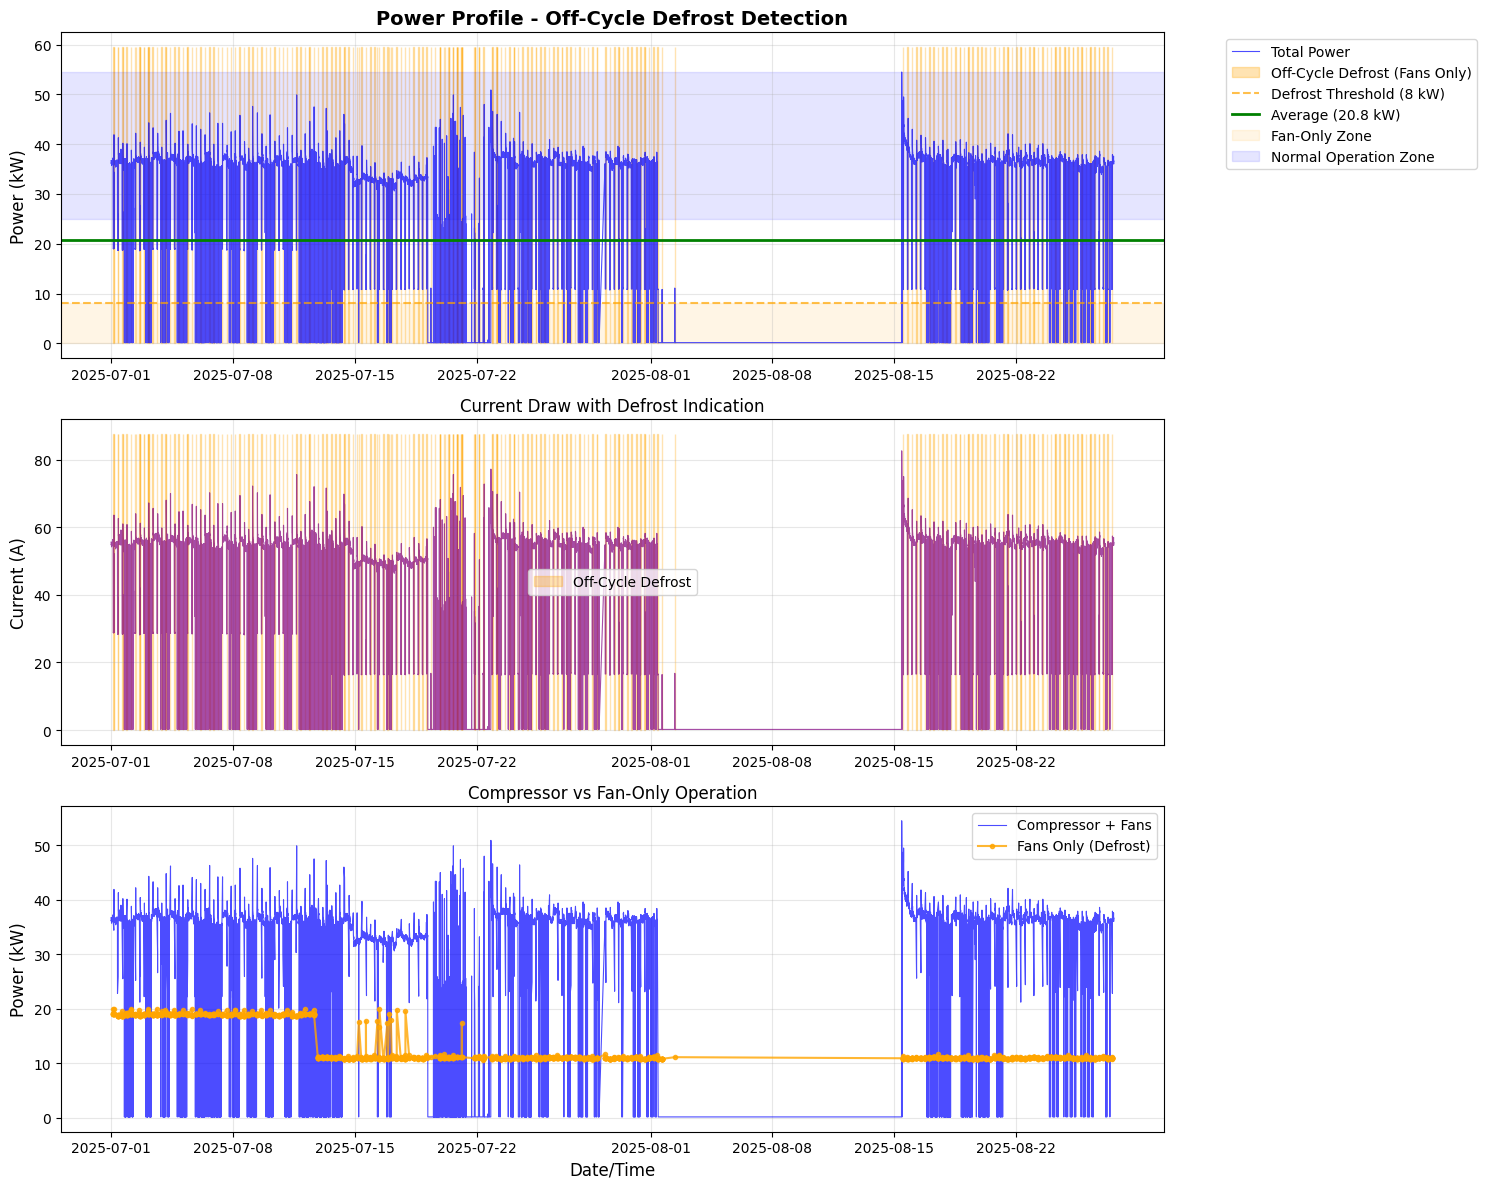

Creating off-cycle defrost analysis...


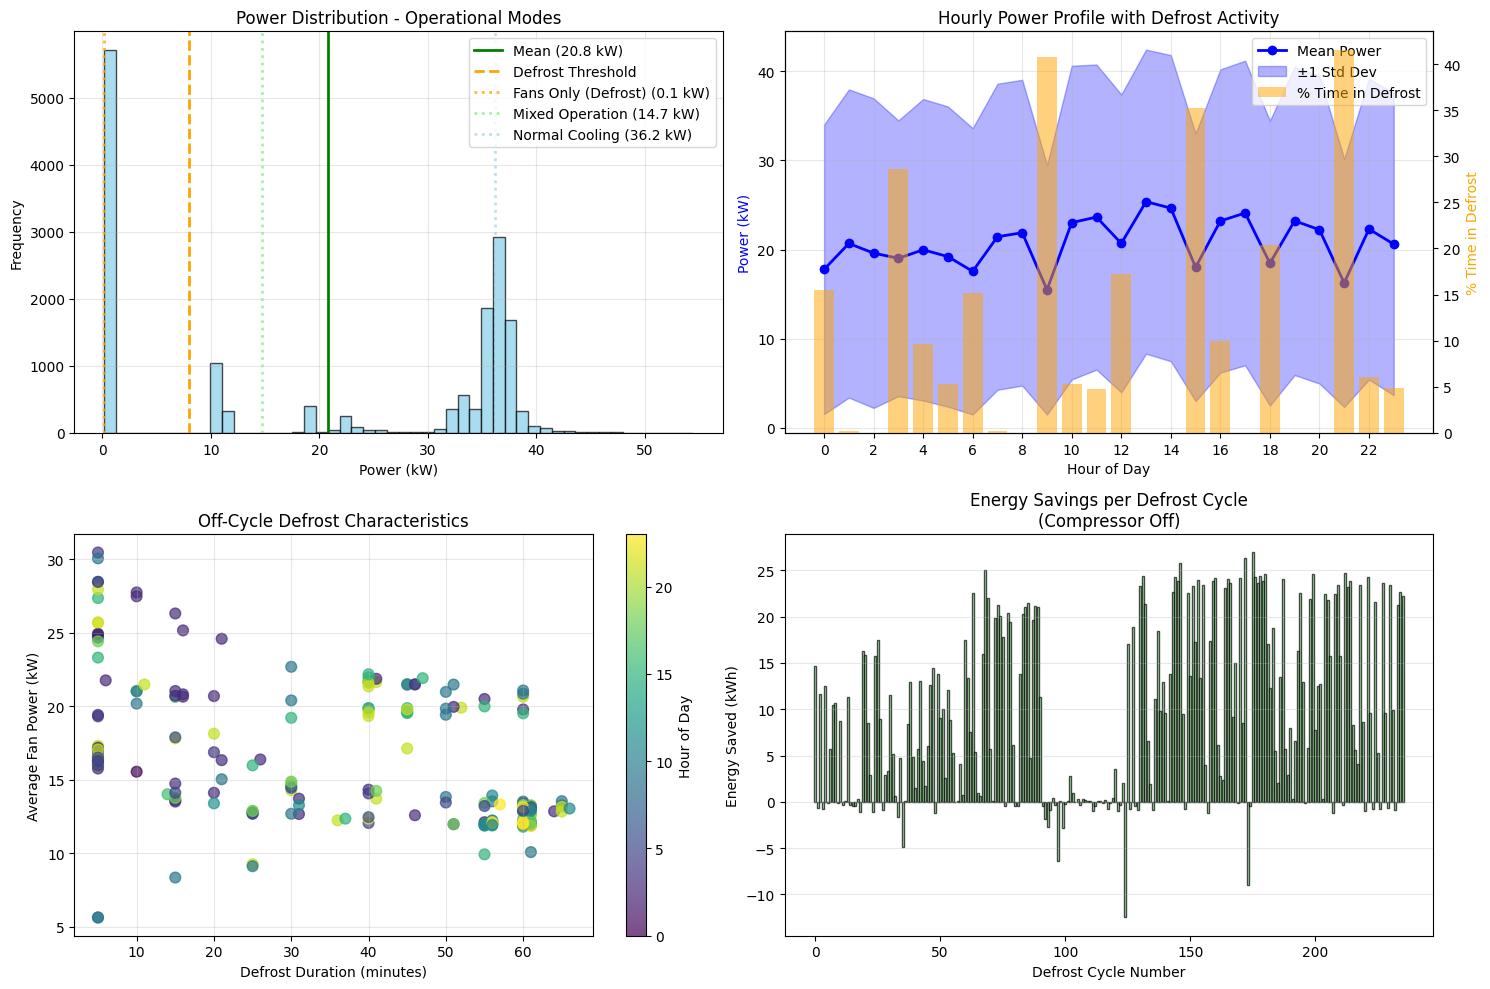

Creating defrost timing and recovery analysis...


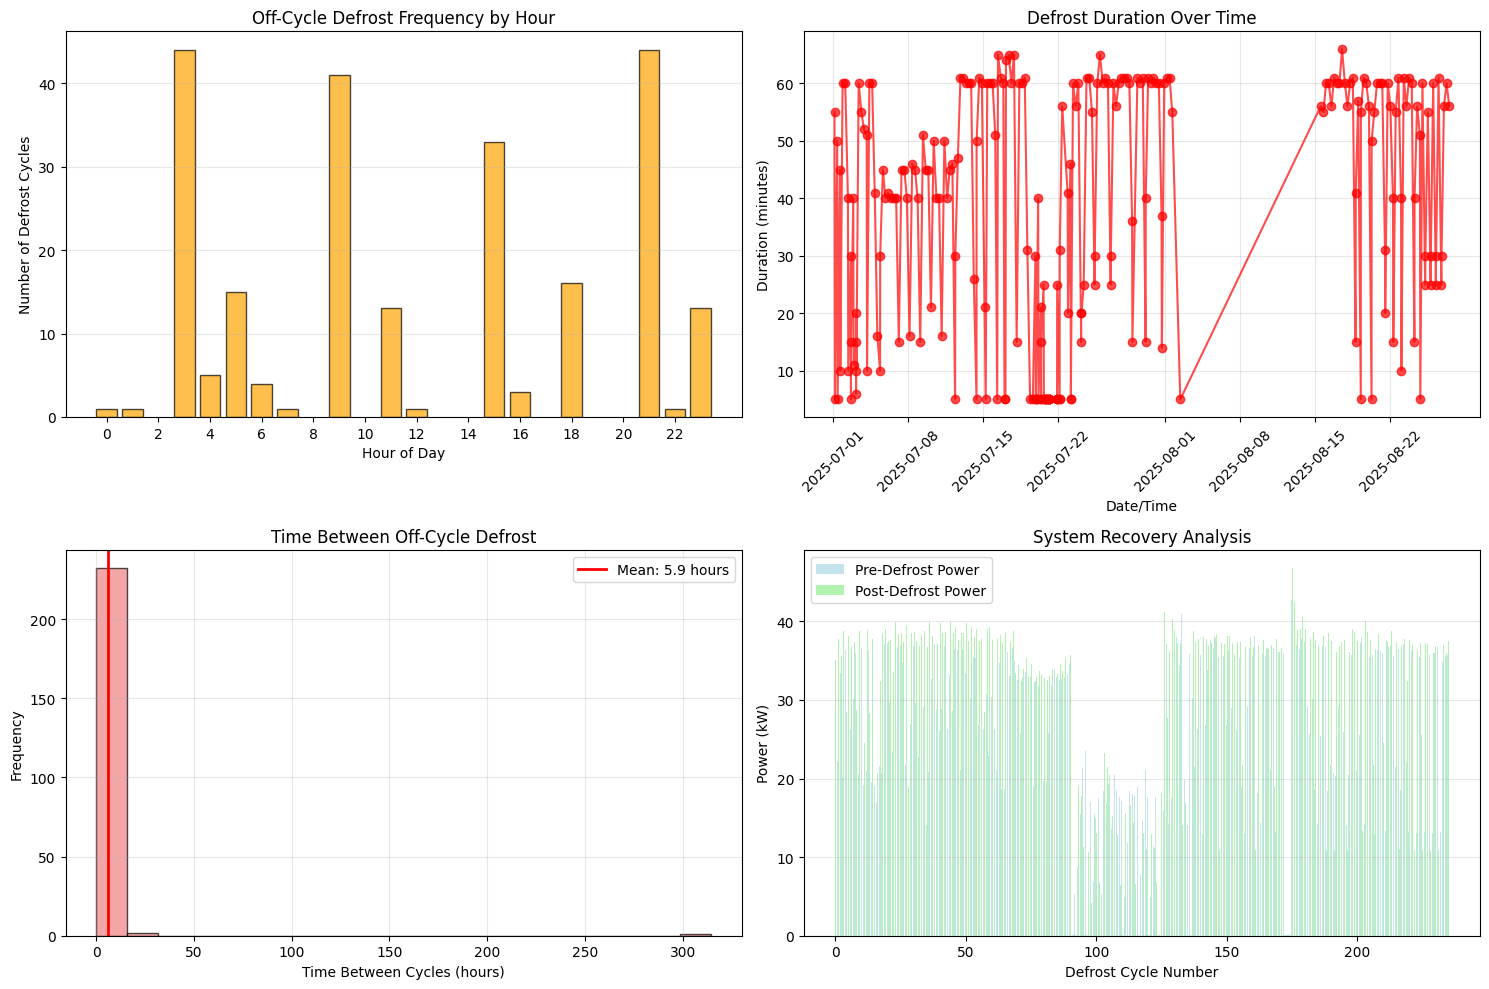

In [66]:
## 5. GENERATE ALL VISUALIZATIONS

print("\n" + "="*70)
print("GENERATING OFF-CYCLE DEFROST VISUALIZATIONS")
print("="*70)

if df is not None:
    # Full power profile with off-cycle defrost
    print("Creating power profile with off-cycle defrost detection...")
    fig1 = plot_off_cycle_power_profile(df_with_defrost, include_defrost=True)
    plt.show()
    
    # Off-cycle defrost analysis
    print("Creating off-cycle defrost analysis...")
    fig2 = plot_off_cycle_analysis(df, defrost_df)
    plt.show()
    
    # Defrost timing and recovery analysis
    print("Creating defrost timing and recovery analysis...")
    fig3 = plot_defrost_timing_analysis(defrost_df, df)
    plt.show()



DATE RANGE ANALYSIS EXAMPLE
Comparing first day vs last day of operation...
First day: 2025-07-01 to 2025-07-02
Last day: 2025-08-26 to 2025-08-27


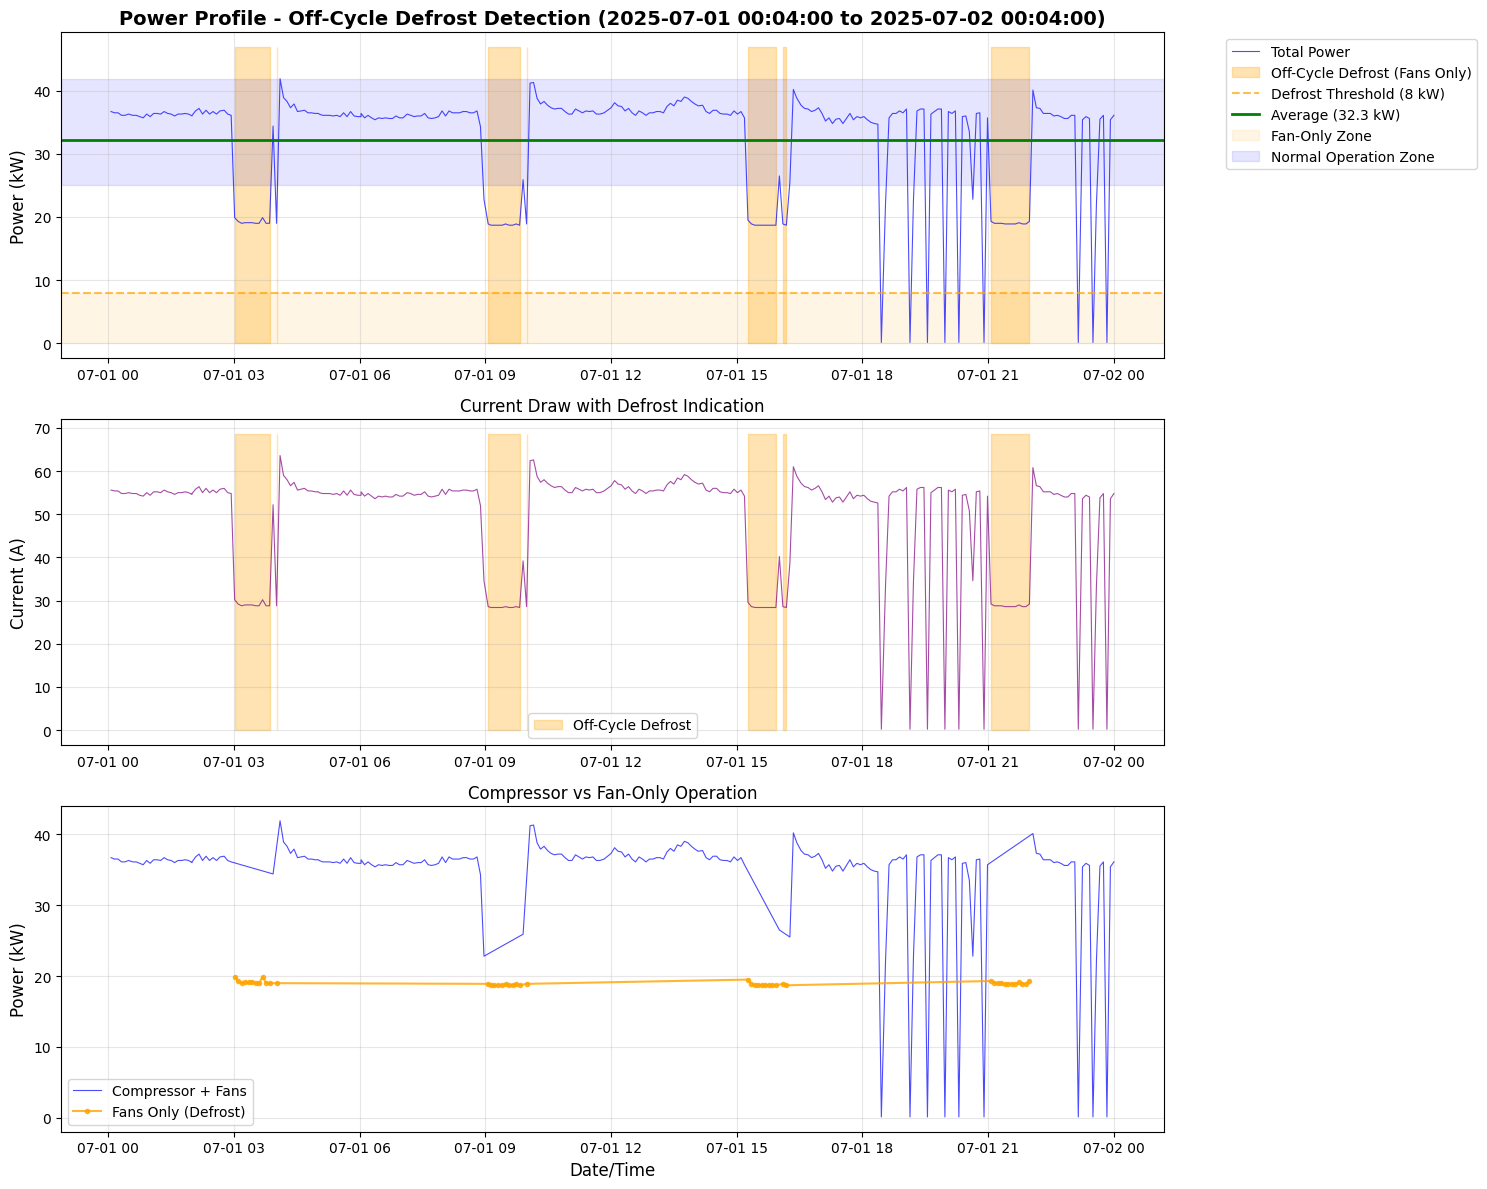

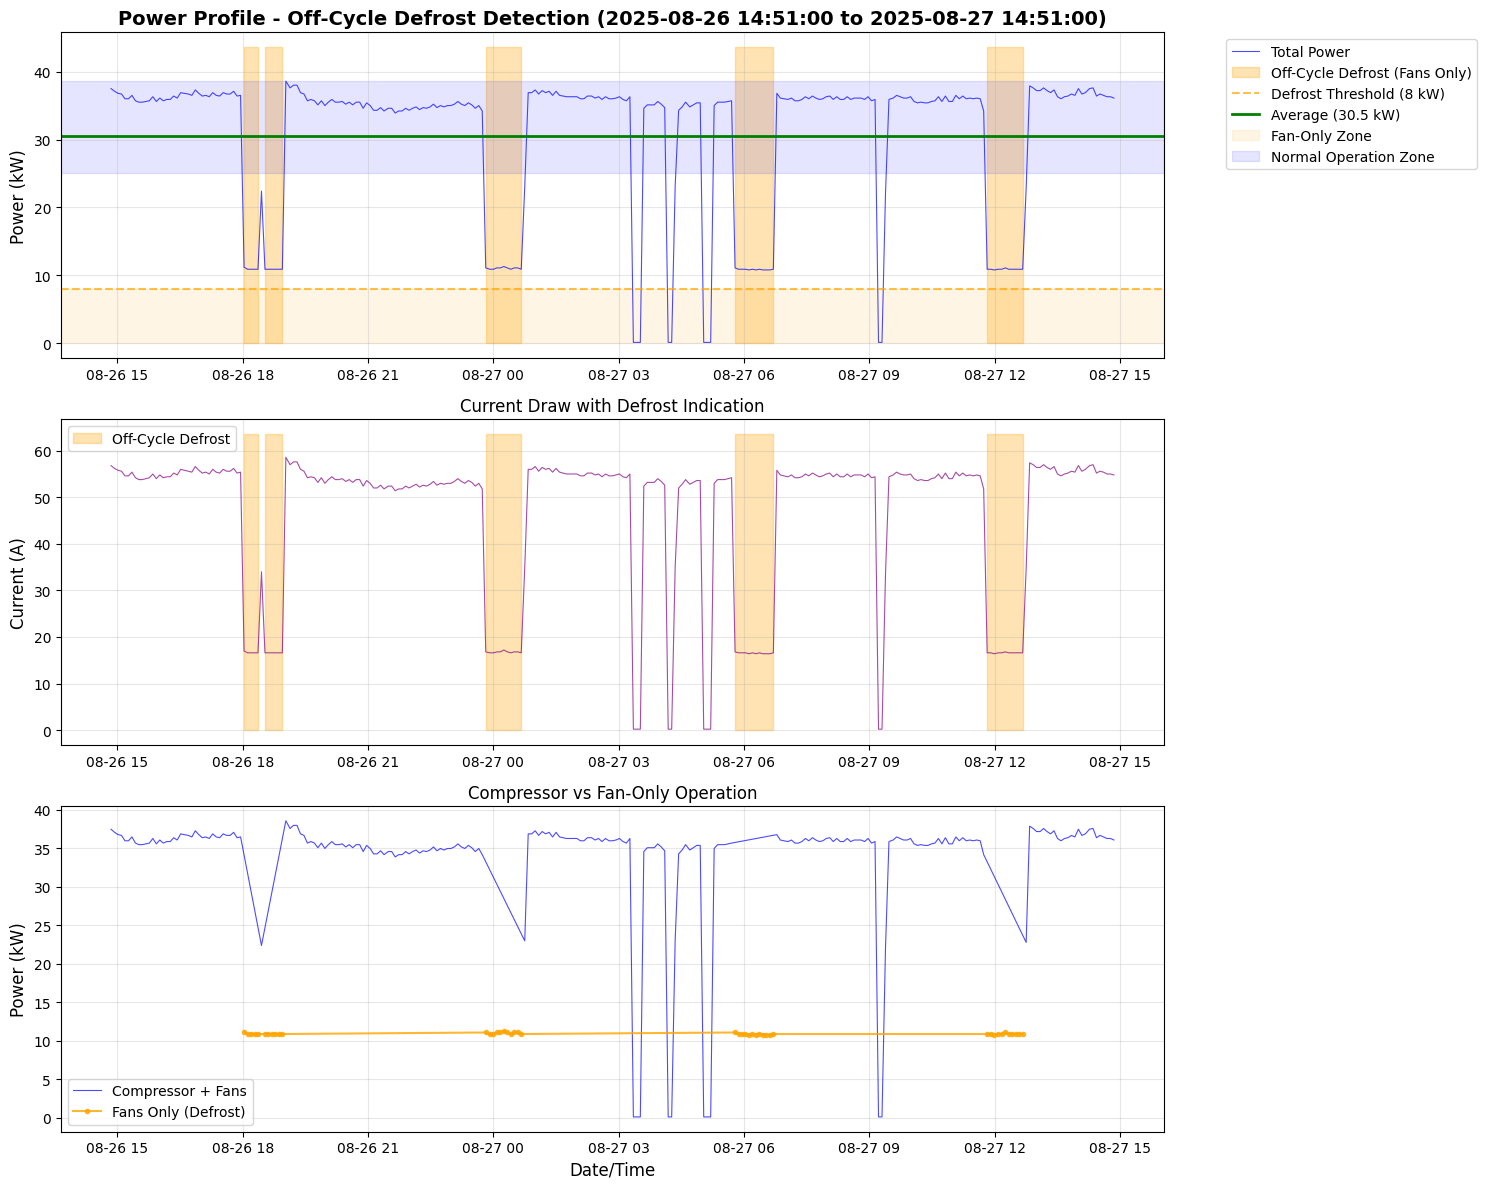

In [67]:
## 6. DATE RANGE ANALYSIS EXAMPLE

print("\n" + "="*70)
print("DATE RANGE ANALYSIS EXAMPLE")
print("="*70)

if df is not None:
    # Get first and last 1 day for comparison
    first_day_end = df['time'].min() + timedelta(days=1)
    last_day_start = df['time'].max() - timedelta(days=1)
    
    print("Comparing first day vs last day of operation...")
    print(f"First day: {df['time'].min().strftime('%Y-%m-%d')} to {first_day_end.strftime('%Y-%m-%d')}")
    print(f"Last day: {last_day_start.strftime('%Y-%m-%d')} to {df['time'].max().strftime('%Y-%m-%d')}")
    
    # Plot first day
    fig4 = plot_off_cycle_power_profile(df_with_defrost, 
                                       start_date=df['time'].min(), 
                                       end_date=first_day_end,
                                       include_defrost=True)
    plt.show()
    
    # Plot last day
    fig5 = plot_off_cycle_power_profile(df_with_defrost, 
                                       start_date=last_day_start, 
                                       end_date=df['time'].max(),
                                       include_defrost=True)
    plt.show()

In [68]:
## 7. OFF-CYCLE DEFROST OPTIMIZATION RECOMMENDATIONS

print("\n" + "="*80)
print("OFF-CYCLE DEFROST OPTIMIZATION RECOMMENDATIONS")
print("="*80)

print("1. DEFROST EFFICIENCY ANALYSIS:")
print("   - Monitor defrost duration trends for frost buildup patterns")
print("   - Optimize defrost frequency based on actual frost accumulation")
print("   - Consider demand-based defrost vs. time-based scheduling")

print("\n2. ENERGY SAVINGS OPPORTUNITIES:")
print("   - Calculate energy savings from compressor shutdown during defrost")
print("   - Evaluate optimal defrost timing to minimize operational impact")
print("   - Consider variable-speed fans during defrost for efficiency")

print("\n3. SYSTEM PERFORMANCE MONITORING:")
print("   - Track system recovery time after defrost cycles")
print("   - Monitor temperature rise during off-cycle defrost periods")
print("   - Establish baseline power consumption patterns")

print("\n4. MAINTENANCE INDICATORS:")
print("   - Increasing defrost duration may indicate coil fouling")
print("   - Changes in fan power during defrost indicate motor issues")
print("   - Power factor degradation suggests electrical maintenance needs")

print("\n5. OPERATIONAL OPTIMIZATION:")
print("   - Schedule defrost during low-demand periods")
print("   - Coordinate with other refrigeration systems to minimize peak demand")
print("   - Monitor ambient conditions impact on defrost frequency")



OFF-CYCLE DEFROST OPTIMIZATION RECOMMENDATIONS
1. DEFROST EFFICIENCY ANALYSIS:
   - Monitor defrost duration trends for frost buildup patterns
   - Optimize defrost frequency based on actual frost accumulation
   - Consider demand-based defrost vs. time-based scheduling

2. ENERGY SAVINGS OPPORTUNITIES:
   - Calculate energy savings from compressor shutdown during defrost
   - Evaluate optimal defrost timing to minimize operational impact
   - Consider variable-speed fans during defrost for efficiency

3. SYSTEM PERFORMANCE MONITORING:
   - Track system recovery time after defrost cycles
   - Monitor temperature rise during off-cycle defrost periods
   - Establish baseline power consumption patterns

4. MAINTENANCE INDICATORS:
   - Increasing defrost duration may indicate coil fouling
   - Changes in fan power during defrost indicate motor issues
   - Power factor degradation suggests electrical maintenance needs

5. OPERATIONAL OPTIMIZATION:
   - Schedule defrost during low-demand pe

In [69]:
## 8. OPERATIONAL INSIGHTS SUMMARY

if df is not None:
    print("\n" + "="*70)
    print("OPERATIONAL INSIGHTS SUMMARY")
    print("="*70)
    
    # System efficiency assessment
    if metrics['load_factor'] > 0.7:
        efficiency_grade = "EXCELLENT"
        efficiency_color = "🟢"
    elif metrics['load_factor'] > 0.5:
        efficiency_grade = "GOOD"
        efficiency_color = "🟡"
    elif metrics['load_factor'] > 0.3:
        efficiency_grade = "FAIR"
        efficiency_color = "🟠"
    else:
        efficiency_grade = "POOR"
        efficiency_color = "🔴"
    
    print(f"{efficiency_color} SYSTEM EFFICIENCY: {efficiency_grade}")
    print(f"   Load Factor: {metrics['load_factor']:.2f}")
    print(f"   Average Power: {metrics['mean_power_kw']:.1f} kW")
    print(f"   Peak Demand: {metrics['max_power_kw']:.1f} kW")
    
    # Defrost system assessment
    if not defrost_df.empty:
        if defrost_metrics['cycles_per_day'] < 4:
            defrost_grade = "EFFICIENT"
            defrost_color = "🟢"
        elif defrost_metrics['cycles_per_day'] < 6:
            defrost_grade = "NORMAL"
            defrost_color = "🟡"
        else:
            defrost_grade = "FREQUENT"
            defrost_color = "🟠"
        
        print(f"{defrost_color} DEFROST OPERATION: {defrost_grade}")
        print(f"   Cycles per Day: {defrost_metrics['cycles_per_day']:.1f}")
        print(f"   Average Duration: {defrost_metrics['avg_cycle_duration']:.1f} minutes")
        # print(f"   Defrost Energy: {defrost_metrics['total_defrost_energy']:.1f} kWh")
    
    print(f"\n📊 KEY PERFORMANCE INDICATORS:")
    print(f"   • Daily Energy Consumption: {metrics['average_hourly_consumption']*24:.1f} kWh/day")
    print(f"   • Power Factor: {metrics['average_power_factor']:.2f}")
    print(f"   • Current Utilization: {(metrics['average_current']/metrics['max_current'])*100:.1f}%")
    print(f"   • System Availability: {(len(df)/2500)*100:.1f}%")  # Assuming 5-min intervals expected
    
    print(f"\n⚡ ELECTRICAL HEALTH:")
    print(f"   • Operating Voltage: {metrics['average_voltage']:.0f} V")
    print(f"   • Power Factor: {metrics['average_power_factor']:.2f} (Target: >0.85)")
    print(f"   • Peak Current: {metrics['max_current']:.1f} A")
    
    print(f"\n🎯 OPTIMIZATION OPPORTUNITIES:")
    if metrics['load_factor'] < 0.5:
        print(f"   • Low load factor ({metrics['load_factor']:.2f}) suggests oversized equipment or poor utilization")
    if not defrost_df.empty and defrost_metrics['cycles_per_day'] > 6:
        print(f"   • High defrost frequency ({defrost_metrics['cycles_per_day']:.1f}/day) may indicate excessive frost buildup")
    if metrics['average_power_factor'] < 0.85:
        print(f"   • Poor power factor ({metrics['average_power_factor']:.2f}) may result in utility penalties")
    
    print(f"\n" + "="*70)
    print("Power meter analysis completed successfully!")
    print("="*70)


OPERATIONAL INSIGHTS SUMMARY
🟠 SYSTEM EFFICIENCY: FAIR
   Load Factor: 0.38
   Average Power: 20.8 kW
   Peak Demand: 54.5 kW
🟡 DEFROST OPERATION: NORMAL
   Cycles per Day: 4.1
   Average Duration: 38.0 minutes

📊 KEY PERFORMANCE INDICATORS:
   • Daily Energy Consumption: 500.7 kWh/day
   • Power Factor: 0.80
   • Current Utilization: 38.1%
   • System Availability: 655.7%

⚡ ELECTRICAL HEALTH:
   • Operating Voltage: 476 V
   • Power Factor: 0.80 (Target: >0.85)
   • Peak Current: 82.6 A

🎯 OPTIMIZATION OPPORTUNITIES:
   • Low load factor (0.38) suggests oversized equipment or poor utilization
   • Poor power factor (0.80) may result in utility penalties

Power meter analysis completed successfully!


In [70]:
# 
df.head()

,time,raw_mamp,ampere,volt,power_factor,power_total,equipment_id,time_diff,apparent_power,reactive_power,is_defrost,is_defrost_int,defrost_change,compressor_on,hour
0,2025-07-01 00:04:00,2.78,55.6,476,0.8,36.7,Hardening Room,NaN,26.4656,0.0,False,0,NaN,True,0
1,2025-07-01 00:09:00,2.77,55.4,476,0.8,36.5,Hardening Room,5.0,26.3704,0.0,False,0,0.0,True,0
2,2025-07-01 00:14:00,2.77,55.4,476,0.8,36.5,Hardening Room,5.0,26.3704,0.0,False,0,0.0,True,0
3,2025-07-01 00:19:00,2.74,54.8,476,0.8,36.1,Hardening Room,5.0,26.0848,0.0,False,0,0.0,True,0
4,2025-07-01 00:24:00,2.74,54.8,476,0.8,36.1,Hardening Room,5.0,26.0848,0.0,False,0,0.0,True,0


In [71]:
# Resample the cleaned data to 5-minute intervals
df_5m = df.resample('5T', on='time').aggregate({
    'is_defrost': 'mean', 'compressor_on': 'mean'
}).reset_index()

# Rename the time to DateTime
df_5m = df_5m.rename(columns={'time': 'DateTime'})

# Fill missing values
df_5m = df_5m.fillna(method='ffill')

# Save the resampled DataFrame to a new CSV file
output_path = os.path.join('~/github/straus-answr/edge/model/training', 'freezer_power_resampled.csv')
df_5m.to_csv(output_path, index=False)